In [1]:
from NotebookLib import *
from GHZ_distribution import *

In [23]:
# Set parameters
probability_of_success = 0.01

# Monte Carlo parameter
mc_trials = 10**5

number_of_threads = 16

repeat_no = 1

In [24]:
sampled_distribution = multiprocessed_sampling_ghz(probability_of_success,mc_trials,number_of_threads,repeat=repeat_no) #55 times faster for p = 0.1

100%|██████████| 16/16 [00:03<00:00,  4.03it/s]


In [25]:
len(sampled_distribution)

203473

In [4]:
size_of_2d = 1000

def sampling_function_GHZ_test(mc_trials,probability_of_success):
    frequency_array = np.zeros(size_of_2d,dtype=int)
    ghz_2d = np.zeros((size_of_2d,size_of_2d),dtype=int)
    
    # Create random generator of the thread
    rand_int_of_thread = int( multiprocessing.current_process()._identity[0] * time.time()*100000 )
    thread_random_generator = np.random.default_rng(seed=rand_int_of_thread)

    ghz_achieved_in = thread_random_generator.geometric(p=probability_of_success, size=mc_trials)

    links_created = np.sum(ghz_achieved_in) 
    linkA = thread_random_generator.geometric(p=probability_of_success,size=links_created)
    linkB = thread_random_generator.geometric(p=probability_of_success,size=links_created)

    t_link = np.maximum(linkA,linkB)
    t_link_divided_list = np.array(np.split(t_link,np.cumsum(ghz_achieved_in)[0:-1]))

    t_diff = np.abs(linkA-linkB)
    t_diff_divided_list = np.array(np.split(t_diff,np.cumsum(ghz_achieved_in)[0:-1]))

    for trial_ind in range(mc_trials):
        ghz_time = ghz_achieved_in[trial_ind]
        links_time = np.sum(t_link_divided_list[trial_ind])

        frequency_array[ ghz_time+links_time] += 1

        ghz_2d[ghz_time+links_time][ t_diff_divided_list[trial_ind][-1] ] += 1
    return frequency_array, ghz_2d


def multiprocessed_sampling_ghz_test(probability_of_success, mc_trials, number_of_threads, repeat=1 ):

    trials_per_thread = int(mc_trials/number_of_threads)

    frequency_array = np.zeros(size_of_2d,dtype=int)
    ghz_2d = np.zeros((size_of_2d,size_of_2d),dtype=float)
    for i in range(repeat):
        with mp.Pool(number_of_threads) as pool:
            parameters = itertools.repeat((trials_per_thread,probability_of_success),number_of_threads)
            for result_arr1,result_arr2 in tqdm.tqdm(pool.istarmap(sampling_function_GHZ_test, parameters),total=number_of_threads):
                frequency_array += result_arr1
                ghz_2d += result_arr2


    frequency_array = np.trim_zeros(frequency_array,trim='b')

    sampled_probability_distribution = frequency_array/np.sum(frequency_array)
    
    ghz_2d_list = [np.array(0) for i in range(size_of_2d)]
    for i in range(size_of_2d):
        if np.sum(ghz_2d[i][:]):
            ghz_2d_list[i] =  np.trim_zeros(ghz_2d[i][:]/np.sum(ghz_2d[i][:]), trim='b')
     
    return sampled_probability_distribution ,ghz_2d_list


In [5]:
probability_of_success = 0.4
mc_trials = 10**7
number_of_threads = 16
repeat_no = 1
sampled_distribution,ghz_test = multiprocessed_sampling_ghz_test(probability_of_success,mc_trials,number_of_threads,repeat=repeat_no) #55 times faster for p = 0.1

100%|██████████| 16/16 [00:07<00:00,  2.02it/s]


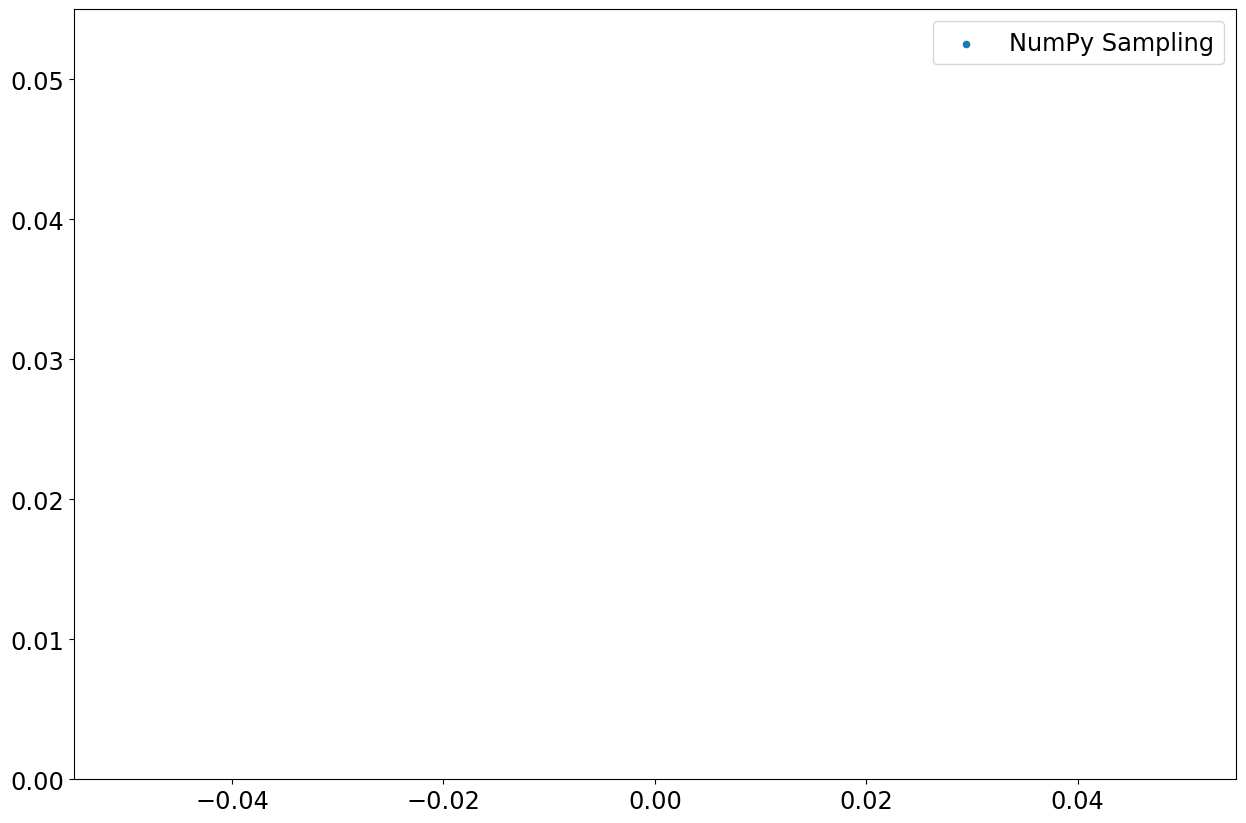

In [7]:
cum_sum_accuracy_decimals = 3

'''max_len = 0
for distr in [mc_distribution, sampled_distribution]:
    cum_distr = np.round(np.cumsum(distr),decimals = cum_sum_accuracy_decimals)
    cut_off_len = np.where(cum_distr==1)[0][0]
    if cut_off_len > max_len:
        max_len = cut_off_len
'''
cut_off_percentage = 0.99
cum_distr = np.cumsum(sampled_distribution)
#cut_off_len = np.where(cum_distr>=cut_off_percentage)[0][0]


#sampled_distribution_cut = np.trim_zeros(ghz_test[4][:],'b') #sampled_distribution[0:cut_off_len] #np.trim_zeros(ghz_test[3][:],'b')#[0:max_len]
sampled_distribution_cut = sampled_distribution[0:-1]
#mc_distribution_cut = mc_distribution[0:max_len]



plt.scatter(y=sampled_distribution_cut,x=np.arange(0,len(sampled_distribution_cut)), label='NumPy Sampling',s =20, alpha=1)
plt.ylim(bottom = 0 )
#plt.scatter(y=mc_distribution_cut,x=np.arange(0,max_len),label='Monte Carlo',s =20, alpha=0.3)
#plt.yscale('log')
plt.legend()

In [9]:
import numpy as np
def ps(n,probability_of_success=probability_of_success):
    '''
    Success after n failed trials.
    '''
    return probability_of_success*(1-probability_of_success)**n

#

max_nn_array = 100
nn_array = np.zeros((max_nn_array,max_nn_array))
for (ind0,ind1), _ in np.ndenumerate(nn_array):
    nn_array[ind0,ind1] = ps(ind0)*ps(ind1)


nn_array_ind = np.dstack(np.unravel_index(np.argsort(nn_array.ravel()), np.shape(nn_array)))[0][::-1]

nn_array_copy = np.copy(nn_array)

nn_array = np.sort(nn_array.flatten())[::-1]
'''
elements_to_delete = []
for (index,element) in enumerate(nn_array_ind):
    n_i , n_j = tuple(element)
    if abs(n_i - n_j) >= decoherence_time:
        elements_to_delete.append(index)

nn_array = np.delete(nn_array,elements_to_delete)
nn_array_ind = np.delete(nn_array_ind,elements_to_delete,axis=0)
'''
nn_array_time = np.zeros_like(nn_array)
for (i,succ_index) in enumerate(nn_array_ind):
    nn_array_time[i] = max(succ_index) +1

max_time_link = int( np.max(nn_array_time) )

p_link_array = np.zeros(max_time_link+1)
mult_link_array = np.zeros(max_time_link+1)
for (ind,tim) in enumerate(nn_array_time):
    p_link_array[int(tim)] += nn_array[ind]
    mult_link_array[int(tim)] +=1 



In [10]:
def kron_delta(a,b=0):
    if a==b:
        return 1
    else:
        return 0

array_size = 100

p_gen = probability_of_success

q_g = (1-probability_of_success)

p_gen_fac = p_gen / (2 - p_gen)

tim_array = np.zeros(array_size)

for i in range(array_size):
    tim_array[i] = p_gen_fac * q_g ** i *(2-kron_delta(i))

In [20]:
t_max = 20
dt_array = np.zeros(t_max-1)
dt_array1 = np.zeros(t_max-1)

probability_of_success = 0.4

def pr_dt(dt,p,t):
    q = 1- p
    return (2 - kron_delta(dt)) * p * q**dt * (1- q **(2*(t-dt-1))) / (1+q)

def pr_dt_1(dt,p,t):
    q = 1- p
    term = p * q**dt * (1- q **(2*(t-dt-1))) / (1+q) 
    corr1 = - p**2 * q**(2*t-6-dt) * (1-kron_delta(dt,t-2))

    return (2 - kron_delta(dt)) * (term + corr1)


for t in range(t_max-1):
    dt_array[t] =  pr_dt(t,probability_of_success,t_max)
    dt_array1[t] = pr_dt_1(t,probability_of_success,t_max)


In [21]:
dt_array[0:5] / np.sum(dt_array)

array([0.25003047, 0.30003656, 0.18002193, 0.10801315, 0.06480788])

In [22]:
dt_array1[0:5] / np.sum(dt_array1)

array([0.25006433, 0.30007718, 0.18004629, 0.10802774, 0.06481659])

In [25]:
tim_array[0:5]

array([0.25  , 0.3   , 0.18  , 0.108 , 0.0648])

In [24]:
ghz_test[20]

array([0.20000265, 0.26499258, 0.17640787, 0.12003338, 0.07902893,
       0.05295746, 0.03568023, 0.02274714, 0.01609186, 0.01041004,
       0.00693341, 0.00483418, 0.00319188, 0.00204625, 0.00161581,
       0.0009271 , 0.00049004, 0.00056288, 0.0010463 ])